In [15]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_management.split_raw_data import TRAIN_NAME
from data_management.get_counts import FileResult, ANALYSIS_NAME
from data_management.dataset_file import DatasetFile
from coqlspclient.coq_structs import TermType
import json

In [2]:
DATA_SPLIT_LOC = "/home/ubuntu/coq-modeling/raw-data/data-points-split/"

In [3]:
file_loc = os.path.join(DATA_SPLIT_LOC, ANALYSIS_NAME)
file_result = FileResult.load(file_loc)

### Examples by Sentence Type

In [8]:
train_loc = os.path.join(DATA_SPLIT_LOC, TRAIN_NAME)
examples: dict[TermType, str] = {}
class Found(Exception):
    pass
for premise_key, count in file_result.avail_aggregator.table_counts.type_freqs.items():
    if premise_key.term_type in examples:
        continue
    try:
        for file_dir in os.listdir(train_loc):
            file_dir_loc = os.path.join(train_loc, file_dir)
            dset_file = DatasetFile.from_directory(file_dir_loc)
            for premise in dset_file.avail_premises:
                if premise.sentence_type == premise_key.term_type:
                    examples[premise_key.term_type] = premise.text
                    raise Found
    except Found:
        pass





In [10]:
for example_type, example_str in examples.items():
    print(f"{example_type.name}: {example_str}")

DEFINITION: Definition not (A:Prop) := A -> False.
TACTIC: Ltac exfalso := elimtype False.
FIXPOINT: Fixpoint nb_digits d := match d with | Nil => O | D0 d | D1 d | D2 d | D3 d | D4 d | D5 d | D6 d | D7 d | D8 d | D9 d | Da d | Db d | Dc d | Dd d | De d | Df d => S (nb_digits d) end.
LEMMA: Lemma iff_and : forall A B : Prop, (A <-> B) -> (A -> B) /\ (B -> A).
THEOREM: Theorem proj1 : A /\ B -> A.
NOTATION: Notation "'if' c 'is' p 'then' u 'else' v" := (match c with p => u | _ => v end) (at level 200, p pattern at level 100).
INDUCTIVE: Inductive True : Prop := I : True.
VARIANT: Variant uint := UIntDecimal (u:Decimal.uint) | UIntHexadecimal (u:Hexadecimal.uint).
SCHEME: Scheme Acc_inv_dep := Induction for Acc Sort Prop.
OTHER: CoFixpoint bind {A B: Type} (d: delay A) (f: A -> delay B) := match d with | now v => later (f v) | later d' => later (bind d' f) end.
INSTANCE: Global Instance StrictOrder_Asymmetric `(StrictOrder R) : Asymmetric R.
CLASS: Class subrelation (R R' : crelation A) 

### Available Premises

In [11]:
def plot_avg_premises(avg_results: dict[str, float],
                      ax_title: str) -> None:
    labels: list[str] = []
    avgs: list[float] = []
    for premise_type_name, avg in avg_results.items():
        print(f"  - {premise_type_name}: {avg}")
        formatted_avg = "{:.2f}".format(avg)
        label = f"{premise_type_name}: {formatted_avg}"
        labels.append(label)
        avgs.append(avg)
    fig, ax = plt.subplots()
    fig.suptitle(ax_title)
    #fig.set_title(ax_title)
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    wedges, text = ax.pie(avgs)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    avg_sum = sum(v for k, v in avg_results.items())
    for i, wedge in enumerate(wedges):
        ang_diff = wedge.theta2 - wedge.theta1
        ang = (ang_diff / 2.) + wedge.theta1
        piece_of_pie = avgs[i] / avg_sum
        if piece_of_pie < 0.01:
            continue 
        rad_ang = np.deg2rad(ang)
        x = np.cos(rad_ang)
        y = np.sin(rad_ang)
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        

Average # of Premises Available by Type:
  - Origin: COQ_STD_LIB; Type: DEFINITION.: 755.736508535695
  - Origin: COQ_STD_LIB; Type: TACTIC.: 174.80922957716396
  - Origin: COQ_STD_LIB; Type: FIXPOINT.: 134.19018432332825
  - Origin: COQ_STD_LIB; Type: LEMMA.: 1371.2585940565536
  - Origin: COQ_STD_LIB; Type: THEOREM.: 350.6894069964387
  - Origin: COQ_STD_LIB; Type: NOTATION.: 523.1196040351462
  - Origin: COQ_STD_LIB; Type: INDUCTIVE.: 70.08124928600166
  - Origin: COQ_STD_LIB; Type: VARIANT.: 7.180523615339913
  - Origin: COQ_STD_LIB; Type: SCHEME.: 3.2357163079704567
  - Origin: LOCAL; Type: THEOREM.: 4.088073868405759
  - Origin: LOCAL; Type: INDUCTIVE.: 2.1565034694110694
  - Origin: LOCAL; Type: OTHER.: 0.6396431746725542
  - Origin: LOCAL; Type: TACTIC.: 0.7917856663901734
  - Origin: LOCAL; Type: LEMMA.: 11.238383557425335
  - Origin: LOCAL; Type: DEFINITION.: 11.1484321838167
  - Origin: LOCAL; Type: NOTATION.: 2.126577625899638
  - Origin: COQ_STD_LIB; Type: INSTANCE.: 139.6

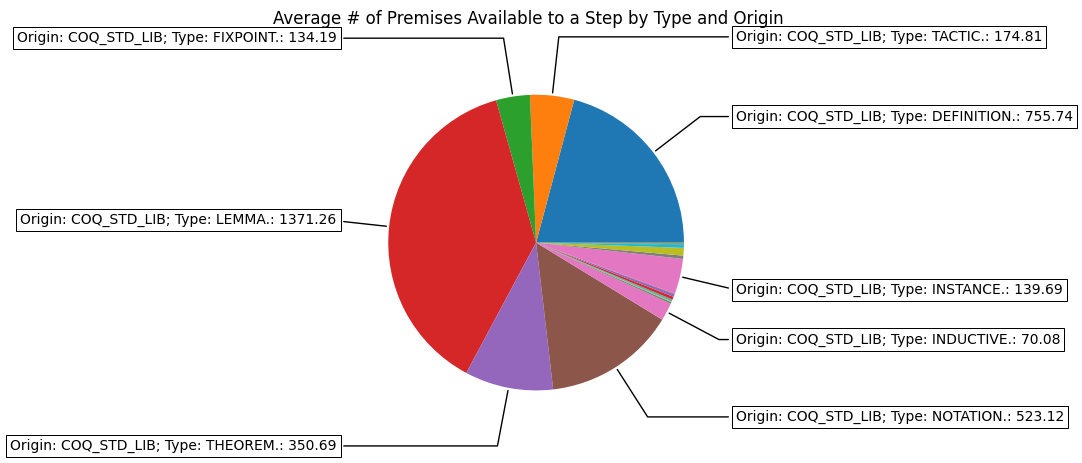

In [14]:
avg_file_results = file_result.avail_aggregator.compute_by_key()
print("Average # of Premises Available by Type:")
plot_avg_premises(avg_file_results, "Average # of Premises Available to a Step by Type and Origin")

In [17]:
entries: list[dict[str, float]] = []
for premise_key, count in file_result.avail_aggregator.table_counts.type_freqs.items():
    entries.append({"Origin": premise_key.origin.name,
                    "Type": premise_key.term_type.name,
                    "Count": count / file_result.avail_aggregator.num_tables})
df = pd.DataFrame(entries)


In [31]:
stacked = df.set_index(["Type", "Origin"]).unstack()
stacked[("Count", "TOTAL")] = stacked[("Count", "COQ_STD_LIB")] + stacked[("Count", "LOCAL")]
stacked.sort_values(("Count", "TOTAL"), ascending=False)

Count                        
Origin       COQ_STD_LIB      LOCAL        TOTAL
Type                                            
LEMMA        1371.258594  11.238384  1382.496978
DEFINITION    755.736509  11.148432   766.884941
NOTATION      523.119604   2.126578   525.246182
THEOREM       350.689407   4.088074   354.777481
TACTIC        174.809230   0.791786   175.601015
INSTANCE      139.694215   0.310459   140.004674
FIXPOINT      134.190184   2.620754   136.810938
INDUCTIVE      70.081249   2.156503    72.237753
CLASS          30.352052   0.064024    30.416076
OTHER          12.963240   0.639643    13.602883
RECORD         11.979119   0.130775    12.109894
VARIANT         7.180524   0.001768     7.182292
SCHEME          3.235716   0.020921     3.256637
REMARK          2.375953   0.019113     2.395066
COROLLARY       2.035255   0.170838     2.206093
FACT            0.017315   0.072999     0.090314
PROPOSITION          NaN   0.926415          NaN

### Positive Premises

Step Needs Premise Freq: 0.3258415246534314
Steps w/ pos prem & period: 0.05827566232736807
Steps w/ pos prem term type freqs:
{
  "Origin: COQ_STD_LIB; Type: NOTATION.": 0.18142739550623457,
  "Origin: COQ_STD_LIB; Type: INDUCTIVE.": 0.1036096460473766,
  "Origin: LOCAL; Type: TACTIC.": 0.018490289930185054,
  "Origin: LOCAL; Type: OTHER.": 0.024618151885613244,
  "Origin: LOCAL; Type: LEMMA.": 0.14510228346696746,
  "Origin: LOCAL; Type: DEFINITION.": 0.13385262644431573,
  "Origin: LOCAL; Type: THEOREM.": 0.05242218225054114,
  "Origin: COQ_STD_LIB; Type: DEFINITION.": 0.07415932441084114,
  "Origin: LOCAL; Type: INDUCTIVE.": 0.07804640102435902,
  "Origin: COQ_STD_LIB; Type: FIXPOINT.": 0.039221365202280416,
  "Origin: LOCAL; Type: FIXPOINT.": 0.03306301637145209,
  "Origin: COQ_STD_LIB; Type: CLASS.": 0.14449254595896466,
  "Origin: COQ_STD_LIB; Type: OTHER.": 0.11423432212432548,
  "Origin: COQ_STD_LIB; Type: LEMMA.": 0.07809213133745922,
  "Origin: LOCAL; Type: CLASS.": 0.009328

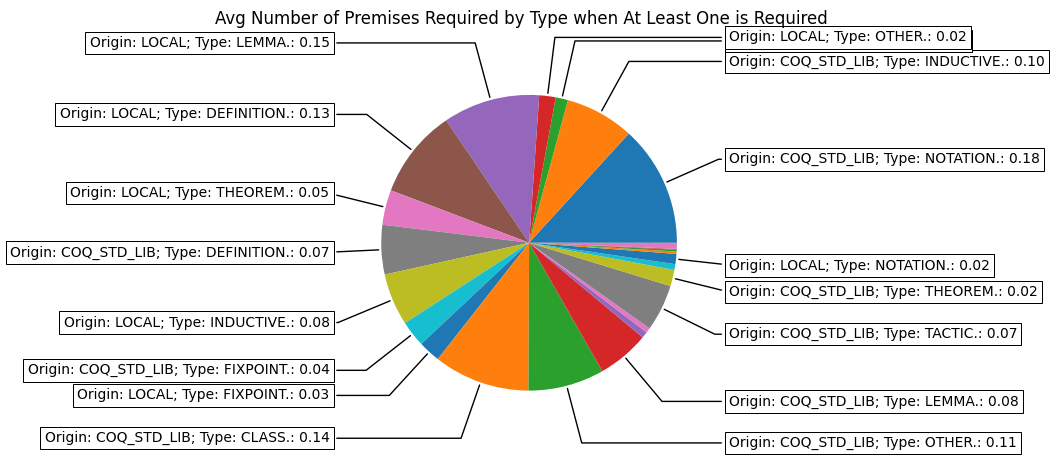

In [13]:
print(file_result.pos_aggregator)
pos_premise_avgs = file_result.pos_aggregator.compute_by_key()
plot_avg_premises(pos_premise_avgs,
                  "Avg Number of Premises Required by Type when At Least One is Required")


In [32]:
entries: list[dict[str, float]] = []
for premise_key, count in file_result.pos_aggregator.table_counts.type_freqs.items():
    entries.append({"Origin": premise_key.origin.name,
                    "Type": premise_key.term_type.name,
                    "Count": count / file_result.pos_aggregator.num_nonempty_premises})
df = pd.DataFrame(entries)

In [33]:
stacked = df.set_index(["Type", "Origin"]).unstack()
stacked[("Count", "TOTAL")] = stacked[("Count", "COQ_STD_LIB")] + stacked[("Count", "LOCAL")]
stacked.sort_values(("Count", "TOTAL"), ascending=False)

Count                    
Origin      COQ_STD_LIB     LOCAL     TOTAL
Type                                       
LEMMA          0.078092  0.145102  0.223194
DEFINITION     0.074159  0.133853  0.208012
NOTATION       0.181427  0.015213  0.196640
INDUCTIVE      0.103610  0.078046  0.181656
CLASS          0.144493  0.009329  0.153822
OTHER          0.114234  0.024618  0.138852
TACTIC         0.070028  0.018490  0.088519
THEOREM        0.024450  0.052422  0.076873
FIXPOINT       0.039221  0.033063  0.072284
RECORD         0.007210  0.008719  0.015929
COROLLARY      0.000015  0.002729  0.002744
INSTANCE       0.000061  0.000960  0.001021
SCHEME         0.000107  0.000442  0.000549
REMARK         0.000030  0.000366  0.000396
FACT                NaN  0.003491       NaN
PROPOSITION         NaN  0.008353       NaN
VARIANT             NaN  0.000229       NaN

In [13]:
sum(file_result.pos_aggregator.table_counts.type_freqs.values())

90043

In [14]:
sum(file_result.avail_aggregator.table_counts.type_freqs.values()) / file_result.num_steps

3626.245630330153